In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from scipy import stats
from src.helpers import *
from src.plot import *

pd.options.display.max_rows = 4000

%matplotlib inline
plt.style.use('ggplot')

In [2]:
waters = pd.read_csv('data/303d_impaired_waters_csv.csv')
dams = pd.read_csv('data/ca_dams.csv')

<AxesSubplot:title={'center':'Counts of Water Body Types in 303(d) Data'}, xlabel='Water Body Type', ylabel='Number of Entries'>

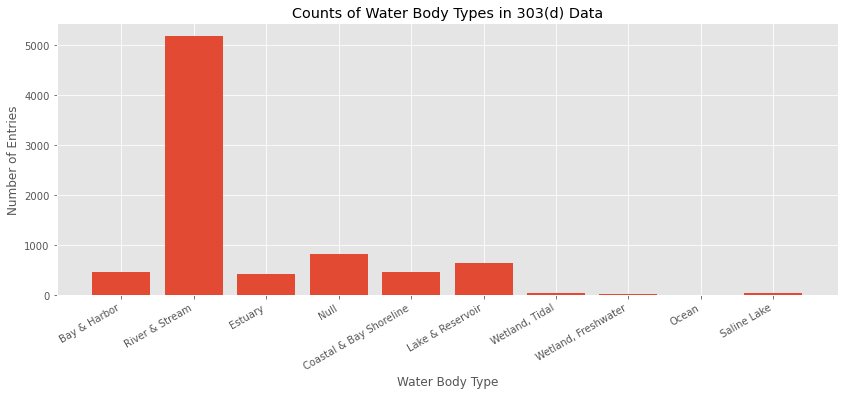

In [3]:
# Display impaired waters vs. type
plot_water_bodies(get_impaired_waters_types(waters, 'WATER BODY TYPE'), 'Number of Water Body Types', (14, 5))


## Clean Data

- We are only looking at River & Stream data
- Filter out all rows with invalide river names
- Filter out all dams data except for river name and private/public

In [4]:
rivers = clean_waters_data(waters)
dams = clean_dams(dams)

## Manipulate Rivers Data

- Groupby 'Water Body Name' and add a new column which is a list of all pollutants of the river
- Drop duplicates
- Add another column which is the total number of all unique pollutants in the river

In [5]:
rivers = condense(rivers)  
reset_index(rivers)
rivers = add_col_num_pollutants(rivers)
rivers.head()

/Users/joshbernd/Desktop/gal_notes/Capstone/dammed_river_impairment/src/helpers.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['All Pollutants'][i] = pollutant_list
/Users/joshbernd/Desktop/gal_notes/Capstone/dammed_river_impairment/src/helpers.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Number of Pollutants'][i] = len(pollutant_list)


,Water Body Name,All Pollutants,Region,Number of Pollutants
0,"bodega hu, estero americano ha, americano creek",[Nutrients],1,1
1,"bodega hu, estero de san antonio ha, stemple c...","[Nutrients, Sediment]",1,2
2,"cape mendocino hu, mattole river ha, mattole r...","[Sedimentation/Siltation, Temperature, water]",1,3
3,"eel river hu, lower eel river ha (includes the...","[Aluminum, Oxygen, Dissolved, Sedimentation/Si...",1,6
4,"eel river hu, middle fork ha, eden valley and ...","[Aluminum, Sedimentation/Siltation, Temperatur...",1,4


## Merge dfs

Merge dfs on the 'Rivers' column

In [6]:
df = merge_dfs(rivers, dams, 'River', 'River')

/usr/local/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


## Plotting

Let's see the counts of dammed rivers vs. natural rivers

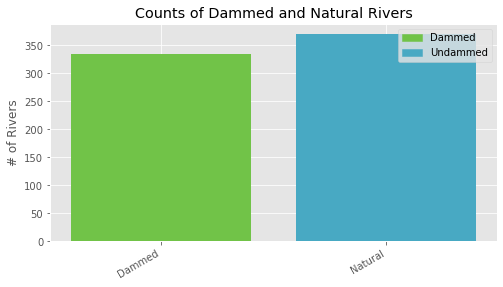

In [7]:
df_dammed = df[df['Private Dam'].notnull()]
natural = df.loc[df['Private Dam'].isnull()]

plot_simple_bar((8,4), [{'Dammed': len(df_dammed)},
                         {'Natural': len(natural)}], 
                        'Counts of Dammed and Natural Rivers', 
                        '# of Rivers', 
                        ['Dammed', 'Undammed'])


# Are dammed rivers more polluted? Let's only investigate the number of different types of pollutants

In [8]:
df_dammed = df[df['Private Dam'].notnull()]
natural = df.loc[df['Private Dam'].isnull()]

Text(0, 0.5, '% of Rivers')

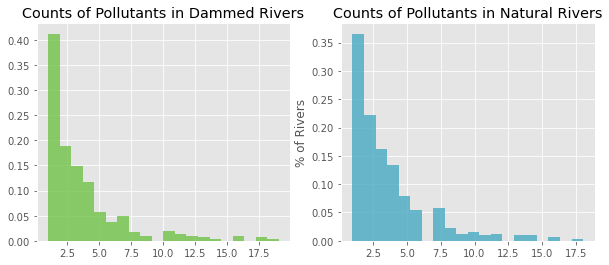

In [34]:
fig, ax = plt.subplots(1,2 , figsize=(10, 4))
_ = ax[0].hist(df_dammed['Number of Pollutants'], bins=20, density=True, color='#71C348', alpha=0.8,
            label="Dammed Rivers")
_ = ax[1].hist(natural['Number of Pollutants'], bins=20, density=True, color='#48A9C3', alpha=0.8,
            label="Undammed Rivers")

_ = ax[0].set_title("Counts of Pollutants in Dammed Rivers")
_ = ax[1].set_title("Counts of Pollutants in Natural Rivers")
plt.ylabel('% of Rivers')

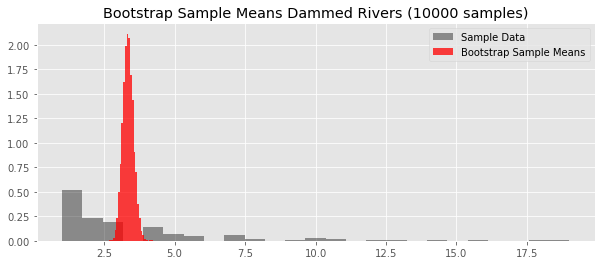

In [10]:
dammed_means = bootstrap_sample_means(df_dammed['Number of Pollutants'])


fig, ax = plt.subplots(1, figsize=(10, 4))
_ = ax.hist(df_dammed['Number of Pollutants'], bins=25, density=True, color="black", alpha=0.4,
            label="Sample Data")
_ = ax.hist(dammed_means, bins=25, density=True, color="red", alpha=0.75,
            label="Bootstrap Sample Means")
ax.legend()
_ = ax.set_title("Bootstrap Sample Means Dammed Rivers (10000 samples)")

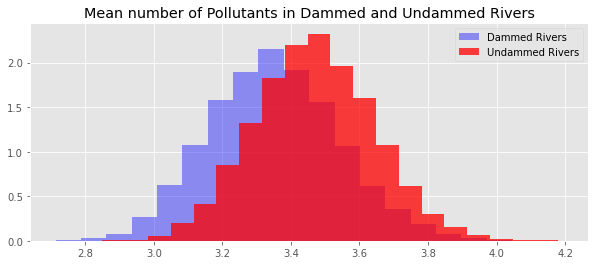

In [11]:
dammed_means = bootstrap_sample_means(df_dammed['Number of Pollutants'])
undammed_means = bootstrap_sample_means(natural['Number of Pollutants'])


fig, ax = plt.subplots(1, figsize=(10, 4))
_ = ax.hist(dammed_means, bins=20, density=True, color="blue", alpha=0.4,
            label="Dammed Rivers")
_ = ax.hist(undammed_means, bins=20, density=True, color="red", alpha=0.75,
            label="Undammed Rivers")
ax.legend()
_ = ax.set_title("Mean number of Pollutants in Dammed and Undammed Rivers")

## Welches Ttest

ho: there is no difference between the number of pollutants for dammed and undammed rivers

ha: there is a difference in the mean number of pollutants

In [12]:
def welch_test_statistic(sample_1, sample_2):
    numerator = np.mean(sample_1) - np.mean(sample_2)
    denominator_sq = (np.var(sample_1) / len(sample_1)) + (np.var(sample_2) / len(sample_2))
    return numerator / np.sqrt(denominator_sq)

In [13]:
t_stat = welch_test_statistic(df_dammed['Number of Pollutants'], natural['Number of Pollutants'])
t_stat

-0.49606436148314914

## Now let's look at the most common 15 pollutants for both dammed and natural rivers:

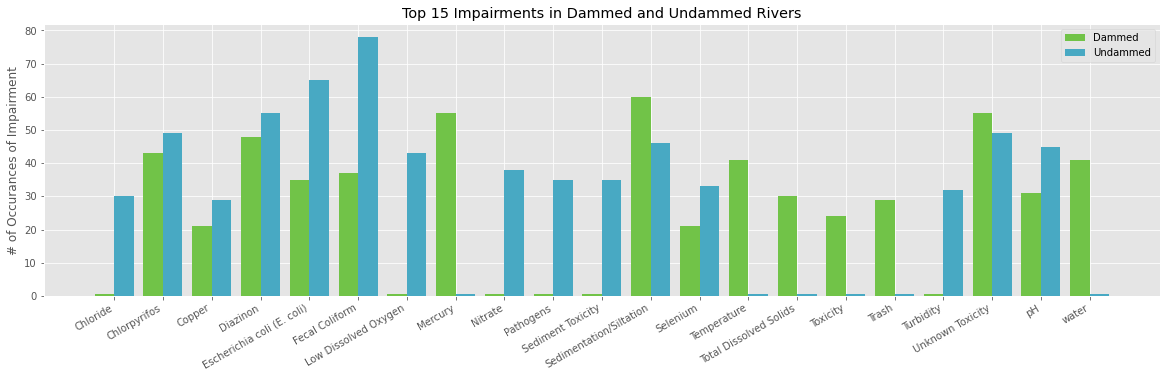

In [14]:
dammed_most_potent = get_first_n(get_pollutant_dict(df_dammed), 15)
undammed_most_potent = get_first_n(get_pollutant_dict(natural), 15)

plot_most_common_pollutants(dammed_most_potent, undammed_most_potent)



## It looks like there is an interesting trend here. Let's get a clean look at the top three most common pollutants

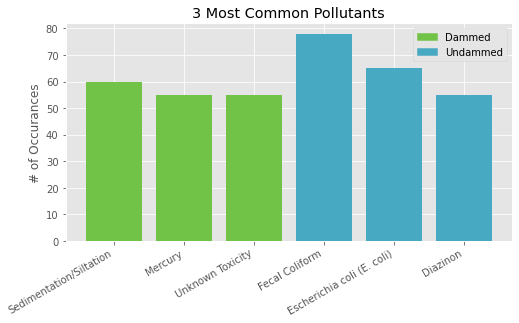

In [15]:
a = get_first_n(get_pollutant_dict(df_dammed), 3)
b = get_first_n(get_pollutant_dict(natural), 3)

plot_simple_bar((8,4), [a,b], '3 Most Common Pollutants', '# of Occurances', ['Dammed', 'Undammed'])

Two interesting things:
- It looks like  the most common pollutants for natural rivers are all point sources
- The most common pollutants for dammed rivers are heavily influenced/cause by reservoir stratification

Point sources are solved by TMDLs, non-point sources are not as easy to fix.
Let's aggregate list of 15 most common pollutants and classify them as 'Treatable' or 'Untreatable':

In [16]:
most_potent = combine_dicts(get_first_n(get_pollutant_dict(df_dammed), 15), 
                            get_first_n(get_pollutant_dict(natural), 15))

## Let's see what we're working with
for k, v in most_potent.items():
    print(k, v)

Sedimentation/Siltation 60
Mercury 55
Unknown Toxicity 55
Diazinon 48
Chlorpyrifos 43
Temperature 41
water 41
Fecal Coliform 37
Escherichia coli (E. coli) 35
pH 31
Total Dissolved Solids 30
Trash 29
Toxicity 24
Copper 21
Selenium 21
Low Dissolved Oxygen 43
Nitrate 38
Pathogens 35
Sediment Toxicity 35
Turbidity 32
Chloride 30


## Grouping Most Common Pollutants into 'Treatable' and 'Untreatable'

- Point sources = treatable

- Chemistry impairments as a result of changing water conditions = untreatable

In [17]:
treatable = {}
treatable['Diazinon'] = 'Yes'
treatable['Sedimentation/Siltation'] = 'No'
treatable['Pathogens'] = 'Yes'
treatable['Low Dissolved Oxygen'] = 'No'
treatable['Fecal Coliform'] = 'Yes'
treatable['Nitrate'] = 'Yes'
treatable['Sediment Toxicity'] = 'No'
treatable['Unknown Toxicity'] = 'No'
treatable['Chlorpyrifos'] = 'Yes'
treatable['Escherichia coli (E. coli)'] = 'Yes'
treatable['pH'] = 'No'
treatable['Chloride'] = 'Yes'
treatable['Turbidity'] = 'No'
treatable['Selenium'] = 'Yes'
treatable['Temperature'] = 'No'
treatable['Mercury'] = 'No'
treatable['Copper'] = 'Yes'
treatable['Total Dissolved Solids'] = 'No'
treatable['Trash'] = 'Yes'
treatable['Toxicity'] = 'No'
treatable['water'] = 'No'


## Plot the proportions of top 15 most prominent pollutants that are feasible solved with implementation of TMDLs

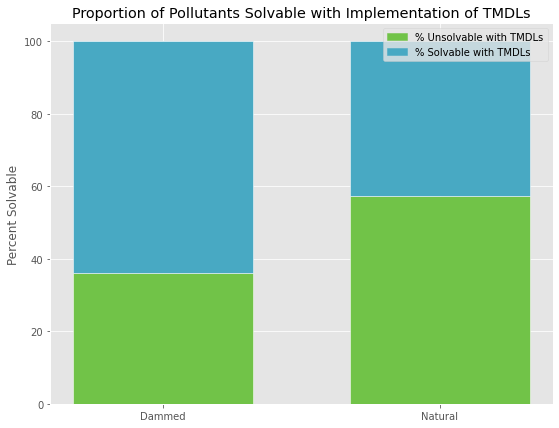

In [18]:
solvability_data = {'Dammed': solvability(dammed_most_potent, treatable),
                    'Natural': solvability(undammed_most_potent, treatable)}

plot_most_potent_stacked_bar(solvability_data)
